# Lab 4, Radio Communication Via a Computer Interface, Part I

Now that you have gotten your radio and radio interfaces, we are ready to experiment with them. In this part of the lab we will learn how to use the interface and the radio, make sure that everything is working correctly so that you will be able to make progress on the second part as well as the project. It is important that you start early, since there may be some technical difficulties you may encounter. 

<center><img src="./usbiface.jpg" alt="gsm" style="width: 400px;"/></center>
<center>Figure 1: The old Computer-Radio Audio Interface. </center>
<center><img src="./newiface.png" alt="gsm" style="width: 400px;"/></center>
<center>Figure 2: The new interface </center>

The interface you got contains a usb hub that connects to your Pi. Make sure the sound card is connected to the hub. When using the Raspberry Pi you will be able to key the radio using one of the General Purpose IO (GPIO) pins, so an extra CP2102 will need to be connected to the hub if you are using a laptop. The interface also has a ground-loop isolation box. It has two audio transformers that prevent voltage potential from your computer to get to the radio. The isolation box has a Kenwood style audio connector with a 2.5mm and 3.5mm audio jack that connects to your Baofeng radio. 

** Unfortunately the USB slots on the pi are quite cramped. It's impossible to plug both the SDR and the USB audio without an extention cord or a USB hub. Connect the SDR straight to the Pi, and use the hub/extension to connect the sound card. 

# You cannot run both the sound card and SDR connected to the hub! It is unreliable due to power issues. 




**Starting:**

* Make sure that the channel you will use is not already in use by someone else
* Choose one of the experimental channels (71-78) in the programmed channels on your radio, preferably a UHF one (75-78)
* Before you start transmitting, you must identify with your call sign and that you intend to use this channel for performing experiments
* Connect the audio interface to the radio and to the USB hub to your computer
* Make sure in alsamixer settings that the volume on the USB interface is set to 20% of the max to prevent overloading the radio input and that both input and output are not on mute. 
* Make sure the output volume on the radio is reasonable to prevent overloading of the usb interface. Turning clockwise when the radio is off for 1/4 of a turn works well for me. 

**During operation:**

* If the green light on the radio turns on frequently, it means that someone is transmitting on your channel. In that case, switch to a different one. 
* If the red light turns on, the radio is transmitting. If it is not supposed to, then something got messed up with the USB to TTL device. It's probably went AWOL due to RF interference.  Unplug the USB hub and plug it back again. Don't forget to reset the notebook kernel
* Announce your callsign every 10 minutes
* Make sure that the antenna is not close to the audio cable and is as orthogonal as possible to it  -- this will prevent RF to get into the audio interface. 
* Sometimes, the usb audio device will stop working due to RF overloading. To prevent that, put your radio further away as possible from the interface.
* Use low-power (# key) when possible

**Finishing:**

* Sign off with your call sign

** RF interference from radio transmission that makes either the USB audio, USB to serial or your USB hub fail is \#1 cause of technical issues in this lab. If that happens **
* Make sure the antenna is not aligned with any cable
* Make sure the radio is far as possible from the interface
* Put your radio on a shelf or elevated
* Ask us for more Ferrite beeds to put on your cables. 
* For this lab, remove the antenna from the SDR -- since you will be transmitting really close to the SDR, you don't want to overload the receiver.  



### Increasing Swap size on the pi


To prevent frustration with memory running out on the pi -- go ahead and increase the SWAP space. To do so follow the following instructions

```
Edit the file:
sudo nano /etc/dphys-swapfile 

Lookfor:
    
CONF_SWAPSIZE=100

and change it to

CONF_SWAPSIZE=2048


Run the following commands:

sudo /etc/init.d/dphys-swapfile stop
sudo /etc/init.d/dphys-swapfile start
```

In [1]:
# set up alsamixer volumes for the raspberry pi

!amixer -c 1 -- sset Mic playback unmute
!amixer -c 1 -- sset Speaker playback unmute
!amixer -c 0 -- sset Speaker playback unmute
!amixer -c 0 -- sset Speaker playback  20%
!amixer -c 1 -- sset Speaker playback  20%
!amixer -c 1 -- sset Mic playback  20%
!amixer -c 1 -- sset Mic capture  75%




Simple mixer control 'Mic',0
  Capabilities: pvolume pvolume-joined cvolume cvolume-joined pswitch pswitch-joined cswitch cswitch-joined
  Playback channels: Mono
  Capture channels: Mono
  Limits: Playback 0 - 14 Capture 0 - 30
  Mono: Playback 12 [86%] [6.00dB] [on] Capture 8 [27%] [0.00dB] [on]
Simple mixer control 'Speaker',0
  Capabilities: pvolume pswitch pswitch-joined
  Playback channels: Front Left - Front Right
  Limits: Playback 0 - 30
  Mono:
  Front Left: Playback 29 [97%] [-1.50dB] [on]
  Front Right: Playback 29 [97%] [-1.50dB] [on]
amixer: Unable to find simple control 'Speaker',0

amixer: Unable to find simple control 'Speaker',0

Simple mixer control 'Speaker',0
  Capabilities: pvolume pswitch pswitch-joined
  Playback channels: Front Left - Front Right
  Limits: Playback 0 - 30
  Mono:
  Front Left: Playback 6 [20%] [-36.00dB] [on]
  Front Right: Playback 6 [20%] [-36.00dB] [on]
Simple mixer control 'Mic',0
  Capabilities: pvolume pvolume-joined cvolume cvolume-joine

In [2]:
# Import functions and libraries

import numpy as np
import matplotlib.pyplot as plt
import pyaudio, threading,time, sys, threading,time, serial
import queue as Queue
from numpy import pi, sin, zeros, r_
from scipy import signal
from rtlsdr import RtlSdr
import sounddevice as sd
import RPi.GPIO as GPIO
%matplotlib inline

Let's first define the spectrogram function, which we will use later in the lab

In [3]:
# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = (len(x)//N)
    x_ = np.reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return r_[-N/2.0:N/2.0]/N*fs, np.mean(abs(X)**2,axis=0)


# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60, fig = None) :
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
    fig=plt.figure(figsize=(16,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    
    return fig


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = np.isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = np.append(x,zeros(-lx+nt*m))
    x = x.reshape((m//2,nt*2), order='F')
    x = np.concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),np.ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * np.hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m//2,:],dbf=dbf)
        print (1)
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

## Audio I/O

We will use the sounddevice python package for audio. 

### Testing the  Audio:

The first test/example would be to see if we can capture audio from the radio and play it on the raspberry pi.

* Connect the audio interface to the radio and to the USB audio dongle. Insert the USB device.
In the new interfaces, connect interface RX to the sound card mic input, and interface TX to the sound card headphone jack
* Connect the speaker to the builtin audio output of the raspberry pi.
* On the radio, press on the orange button to switch to FM radio mode. Tune to 94.1 KPFA. Set the volume at quarter of a turn. You can also tune to NOAA Weather 162.400MHz. Alternatively, you can also tune to the SPLXCAL frequency (ch4 or 146:430MHz on your radio) and ask a friend to transmit to you to see if you can hear the result through the speakers. 
* The following code records the audio that is coming out of the radio into the usb port and plays it on the computer built-in speakers. Study it! It will be very usefull in the future. 

#### An important feature in this task is that you will have a method to check if the incoming signal is being clipped. Remember the settings for which the signal maximum is 0.6.  This would be VERY useful in the communications part of the lab

The following command will list the audio devices on your pi. You should see:
```
 0 bcm2835 ALSA: - (hw:0,0), ALSA (0 in, 2 out)
  1 bcm2835 ALSA: IEC958/HDMI (hw:0,1), ALSA (0 in, 2 out)
  2 USB PnP Sound Device: Audio (hw:1,0), ALSA (1 in, 2 out)
  3 sysdefault, ALSA (0 in, 128 out)
  4 dmix, ALSA (0 in, 2 out)
* 5 default, ALSA (1 in, 2 out)
```

You may see something slightly different than the above. 
But, if you don't see a USB device, then it means that the USB audio is not connected or is not functioning. 

In [4]:
sd.query_devices()


  0 bcm2835 ALSA: - (hw:0,0), ALSA (0 in, 2 out)
  1 bcm2835 ALSA: IEC958/HDMI (hw:0,1), ALSA (0 in, 2 out)
  2 USB Audio Device: - (hw:1,0), ALSA (1 in, 2 out)
  3 sysdefault, ALSA (0 in, 128 out)
  4 dmix, ALSA (0 in, 2 out)
* 5 default, ALSA (1 in, 2 out)

Manually set the audio device numbers. 

builtin_idx should be the bcm2835 ALSA, but not the one with HDMI

usb_idx should be the USB audio


In [7]:
builtin_idx = 0
USB_idx = 2

In [8]:
# set default sample rate and number of channels. 

sd.default.samplerate=48000
sd.default.channels = 1

In [7]:
# this callback function will play captured data 
# it will be called by the soundevice stream and run in a different thread

def replay_callback(indata,outdata, frames, time, status):
    if status:
        print(status)
    outdata[:] = indata  # the [:] is important so data is copied not referenced !
    
 
# create stream
# Will record from device 5 and play through device 3 
st = sd.Stream(device=(USB_idx,builtin_idx),callback=replay_callback)


# start stream -- will run in background till stopped
st.start()

# sleep 15 seconds
time.sleep(15)

# stop and close stream -- must stop and close for clean exit

st.stop()
st.close()

The following callback will do exactly the same thing as before. The only difference is that the received audio will be pushed to a Queue so we can process it outside of the callback function. Default block-sizes are 512 samples, which is about 10ms worth of samples. 

We will capture just over 10 seconds, about 1000 blocks. The samples from the queue will be processed. We will compute the maximum signal and the root-mean-square (RMS) for each block. This will let us see if the signal is being clipped. 

In [8]:
def queuereplay_callback(indata,outdata, frames, time, status):
    if status:
        print(status)
    outdata[:] = indata
    Qin.put( indata )  # Global queue





In [9]:



# create an input FIFO queue
Qin = Queue.Queue()

st = sd.Stream( device=(USB_idx, builtin_idx),callback=queuereplay_callback)

st.start()

# record and play about 10.6 seconds of audio 1000*512/48000 = 10.6 s
mxpwr = zeros(1000)
rmspwr = zeros(1000)

for n in range(0,1000):
    
    samples = Qin.get()
    mxpwr[n] = max(abs(samples))
    rmspwr[n] = np.sqrt(np.sum(np.square(samples)))
    # You can add code here to do processing on samples in chunks of 512 samples
    # In general, you will have to implement an overlap and add, or overlap an save to get
    # continuity between chunks -- we will do this later!
    
st.stop()
st.close()

# empty queue just in case there's something left
while not(Qin.empty()) :
    samples=Qin.get()


* The code also displays the RMS power and Maximum audio signal for each 4800 samples block -- so you can see if it is clipped, or too weak.

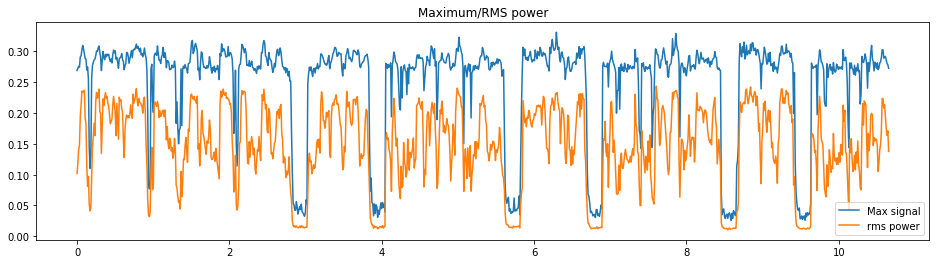

In [10]:
fig = plt.figure(figsize=(16,4))
t = r_[0:1000]*512/48000
plt.plot(t,mxpwr)
plt.plot(t,rmspwr/np.sqrt(512))
plt.title('Maximum/RMS power')
plt.legend(('Max signal','rms power'))

if any(mxpwr > 0.95):
    print("Warning! Signal is clipped. Reduce radio volume, and/or usb device input volume")
if max(mxpwr) < 0.3:
    print("Audio Volume may be too low. Increase the volume on the radio for better lab performance")

Make sure you set the volume such that the peak is not higher than 0.8

### Testing  Radio Transmit control

The next step is to test if the PTT control using the general purpose IO pins (GPIO) on the Raspberry Pi

* Follow the preparation steps listed in the beginning of the document (identify your callsign and announce testing)
* Pick an experimental channel 71-78
* Set the power of the radio to low if it's not set already (short press the # key. shows up as a small 'L')

* Connect the jumper cables from the interface to the GPIO pins. Connect the ground to Pin number 9, and the other to pin number 12. On the standalone isolaters, the ground is marked by blue tape. On the plexiglass-based interfaces, ground is the red jumper. Note, on the plexiglass models, you may find it useful to use a jumper extension.

<center><img src="./pinout.jpg" alt="gsm" style="width: 400px;"/></center>
<center>Figure 2: Raspberry pi pinout</center>

The following code generates a series of 10 short key-on, key off. To key the radio, you need to set the DTR pin of the USB to serial device to '1' and to stop keying set it back to '0'  

If the red light turns on and off, you are good to go!


## WARNING: This is where things may fail to to RF interference. If your radio does not stop transmitting, unplug the USB from your computer! Look above for tips for solving interference problems. **

In [9]:
GPIO.setmode(GPIO.BOARD)

In [10]:

PTT = 12
GPIO.setup(PTT, GPIO.OUT, initial = 0)

for n in range(0,10):
    GPIO.output(PTT, GPIO.HIGH)
    time.sleep(0.25)
    GPIO.output(PTT, GPIO.LOW)
    time.sleep(0.25)



# Transmitting Audio from the Pi to the radio



Below is a code that: 
- keys the radio
- plays a 2KHz tone for 2 second
- unkeys the radio
- keys the radio and plays a 1kHz tone for 2 seconds 
- unkeys the radio.

Use a friend's radio or the SDR (with Gqrx) to make sure you hear the audio. 


In [11]:


# generate sinusoids
t = r_[0:2*48000]/48000
sig2 = 0.5*sin(2*pi*2000*t)
sig1 = 0.5*sin(2*pi*1000*t)

GPIO.output(PTT, GPIO.HIGH) # Key radio
time.sleep(0.1) #give radio time to start
# play audiodio on the USB card. When blocking is True, then this will run in the foreground
sd.play(sig2,device=USB_idx,  blocking=True)  
GPIO.output(PTT, GPIO.LOW)

time.sleep(0.5)

GPIO.output(PTT, GPIO.HIGH)
time.sleep(0.1) #give radio time to start
sd.play(sig1,samplerate=48000,device=USB_idx,  blocking=True)
GPIO.output(PTT, GPIO.LOW)




### Calibrating the Input Audio level to the radio using Radio transmission and reception with the SDR. 

The audio input to the radio is filtered in the radio by a bandpass filter, which passes frequencies roughly between 500Hz and 4KHz. The input filter also emphasizes the high frequencies with approximately 6db per decade up to 3000Hz. 

In later parts of the lab, we will send audio to the radio which encodes digital data. It is important that we have a way to set the right level of outputs such that there's no overdriving and clipping of the signal. 

In this task, we will transmit a pure audio tone with increasing amplitude, receive and demodulate with the SDR and determine the amplitude in which the signal is still "Well behaved" and not clipped or have non-linearities. 

How will it work: 
* We will generate a tone with increasing amplitudes in python
* The USB audio interface will convert it to an analog signal -- acting as an DAC.
* The radio will filter the input with its bandpass filter
* The radio will FM modulate the signal with $\pm7.5$KHz deviation at the chosen center frequency and transmit the FM signal.
* The SDR will capture samples around that center frequency
* You will implement a carrier squelche that would crop the samples corresponding to the transmission.
* you will FM demodulate the signal by implementing a low-pass filter, limiter, discriminator similarly to lab 3. 
* You will then look at the amplitude of the received tone. The amplitude should increase linearly at first, then taper off and saturate. You need to figure out what are the audio amplitude values in the linear regime. The range of volumes you will get will correspond to the range of audio signals with your audio settings that will not be distorted!

#### Setup
* Connect the SDR to a USB port on the Pi (not the hub!).
* Disconnect the antenna from the SDR -- the signal will be stong anyways and we don't want to saturate the SDR. 
* Place the radio as far away from the SDR as possible to minimize interference
* Set your radio to one of the experimental channel on the radio (channels 71-78) with low-power. It's recommended to use the UHF channels 75-78 first-- but if they are occupied use the VHF.


#### Pre-Task:  Setting the gain of the SDR and calibrating the frequency

It is important to know that even though we set a transmit and receive frequency, the frequency the radio is transmitting, and the frequency the SDR is receiving may not be exactly the same. This is because the crystal oscillator on the radio is rated to about 1ppm, and the SDR is rated to about 70ppm deviation.  
Before we start, we would like to make sure that the SDR frequency is calibrated to the radio (both may have some offset). We would also like to adjust the gain of the SDR, so it is not under/overdriven by the radio. 

For this, we only need to key the radio and receive using the SDR. This will transmit a carrier at the center frequency. We will look at the spectrum to see the offset between the transmitted frequency and the received one. We will then calibrate the offset of the SDR with respect to the radio. The SDR has a parameter "ppm" for prescribing known frequency offsets.

We will also look at the magnitude signal to see if its clipped. 

* Acquire 2 seconds of data while the radio is being keyed
* Plot the amplitude of the signal.  Make sure the amplitude of the signal is > 0.25, and < 0.75, if not, change the gain of the SDR or move the SDR away from the radio
* Plot the average power specrum, or the spectrogram, and calculate the offset frequency. Find its approximate frequency offset in parts-per-millon (ppm). 
* Repeat the above till the magnitude of the signal is within range and its frequency is centered. 
* Record the sdr gain and the ppm shift. You will need to use it later.




In [12]:


# Setup SDR
fs_sdr = 240000
fc = 443650000 # set your frequency!
ppm = 23  # 1 recommended
gain = 25.4  # 24 recommended 



sdr = RtlSdr()
sdr.sample_rate = fs_sdr    # sampling rate
sdr.gain = gain
sdr.center_freq = fc
sdr.freq_correction = ppm

# start transmitting
GPIO.output(PTT, GPIO.HIGH)
y = sdr.read_samples(256000)
# stop transmitting
GPIO.output(PTT, GPIO.LOW)

print(sdr.valid_gains_db)
sdr.close()



[0.0, 0.9, 1.4, 2.7, 3.7, 7.7, 8.7, 12.5, 14.4, 15.7, 16.6, 19.7, 20.7, 22.9, 25.4, 28.0, 29.7, 32.8, 33.8, 36.4, 37.2, 38.6, 40.2, 42.1, 43.4, 43.9, 44.5, 48.0, 49.6]


shift in Hz: 9029.0625
shift in ppm: 3.0


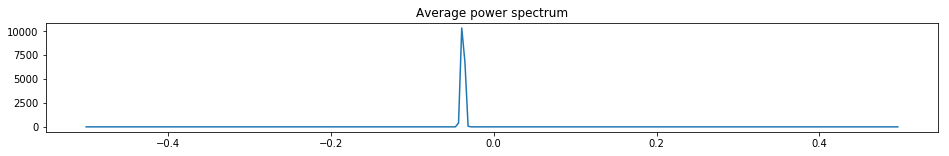

In [13]:
# Code to plot magnitude and compute frequency. Use avgPS to get the spectrum
# Here:
Y_avg = avgPS(y)
fig = plt.figure(figsize=(16,2))
plt.title('Average power spectrum')
plt.plot(Y_avg[0], Y_avg[1])


# Code to compute f0 -- the measured frequency of the carrier
#code inspired by https://stackoverflow.com/questions/3694918/how-to-extract-frequency-associated-with-fft-values-in-python#3695448
w = np.fft.fft(y)
freqs = np.fft.fftfreq(len(w))
idx = np.argmax(np.abs(w))
freq = freqs[idx]
f0 = abs(freq * fs_sdr)


# set correction values
ppmcalib = ppm - np.round(f0/fc*1000000)
gaincalib = gain


print('shift in Hz:', f0)
print('shift in ppm:',ppmcalib)

Now that the SDR frequency and gain are calibrated, let's start with the calibration of the audio level to the radio.

#### Task
 
* Generate a 2 seconds tone at 2200Hz. The tone amplitude should vary linearly from 0 to 1 throughut the 2 seconds.
* Add 250ms worth of zeros in the beginning of the array.
* Transmit the signal using the radio and simultaniously receive using the SDR for 3 seconds. 
* Plot the Spectrogram of the received signal. Do you see that the bandwidth is increasing?



In [14]:
# code to generate the tone
t = r_[0:2:(1/48000)]
pre = zeros(1200) #250ms
s_tone = sin(2*pi*2200*t)
amp = 0.5*t
sig = np.append(pre, amp*s_tone)


# Setup SDR
fs_sdr = 240000
fc = 443650000   # set your frequency!

sdr = RtlSdr()
sdr.sample_rate = fs_sdr    # sampling rate
sdr.gain = gaincalib
sdr.center_freq = fc
sdr.set_freq_correction(int(ppmcalib))



# key radio
GPIO.output(PTT, GPIO.HIGH)
# play tone -- non blocking
sd.play(sig,samplerate=48000,device=USB_idx,  blocking=False)



# read samples from SDR
y = sdr.read_samples(256000*2)

# stop transmitting when done
GPIO.output(PTT, GPIO.LOW)
sdr.close()


#### Task


* Plot the magnitude of the receive signal, and pick a threshod to crop the samples corresponding to the transmission. 
* Again, make sure the amplitude of the signal is  > 0.25, and  < 0.75, if not, change the gain or move the SDR away from the radio
* Crop the signal to the transmission part -- make sure you have  > 2 seconds of data

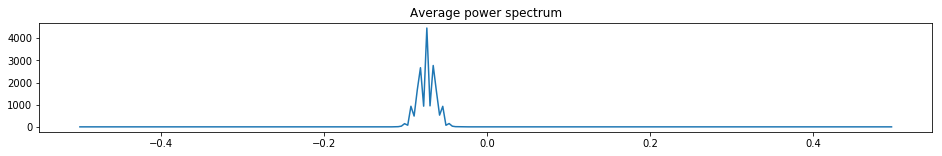

In [15]:
# your code here:
Y_avg = avgPS(y)
fig = plt.figure(figsize=(16,2))
plt.title('Average power spectrum')
plt.plot(Y_avg[0], Y_avg[1])




#### Task
* Plot the spectrogram. Make sure the signal is close to the center frequency, if not, adjust the frequency correction ppm accordingly. 
* Can you see the bandwidth increasing and then leveling? Why is that happening?


([0.0, 2.1333333333333333],
 [443530000.0, 443770000.0],
 array([[ 0.01356055+0.00795371j,  0.01256886+0.01773788j,
          0.00367751-0.01413847j, ..., -0.01756149-0.02658344j,
          0.00839119-0.00833598j,  0.06714470-0.07312536j],
        [-0.01536672+0.00660507j,  0.00857731-0.01039591j,
          0.00156274+0.00352504j, ...,  0.03428915+0.04406713j,
          0.00116563-0.00600396j, -0.07814050+0.06802746j],
        [ 0.01883450-0.01194655j, -0.02070477+0.00855575j,
         -0.00490006-0.00833729j, ..., -0.03217169-0.04033803j,
         -0.00644052+0.01553981j,  0.07312779-0.06418954j],
        ..., 
        [-0.01664515-0.020127j  ,  0.00583481+0.01726591j,
         -0.01149098-0.00671465j, ...,  0.02060587+0.01425507j,
         -0.01440642-0.05014395j, -0.08629331+0.06638722j],
        [ 0.02449985-0.00211818j,  0.01312868-0.01377763j,
          0.00605038-0.01144001j, ...,  0.02834652-0.03045724j,
          0.02425792+0.04734229j,  0.07939250-0.05028541j],
        [-0.01

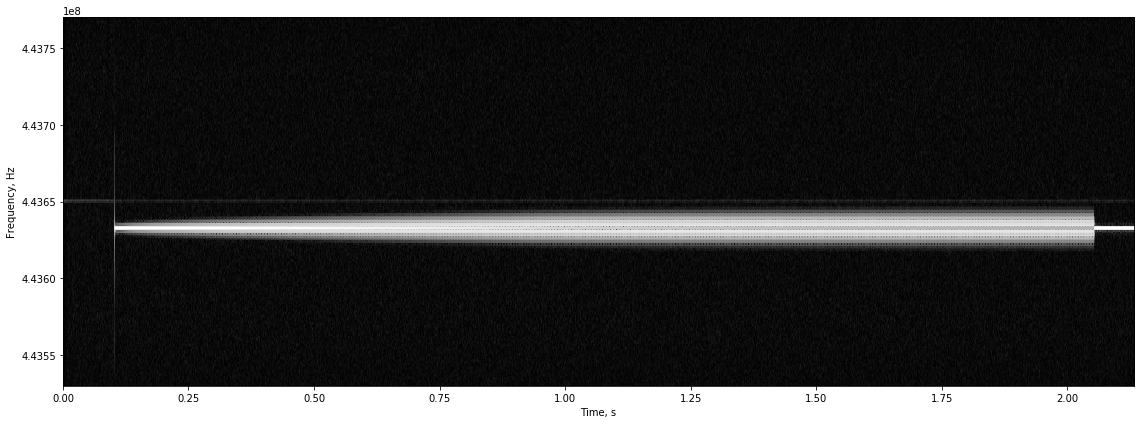

In [16]:
# Your code here
myspectrogram_hann_ovlp(y, 256, fs_sdr, fc)




#### Task
* Low-pass filter with a bandwidth of 15KHz
* Downsample by 10 to 24KHz effective sampling rate
* FM - demosulate using the approach in Lab 3
* plot the spectrogram of the demodulated signal.


1


([0.0, 0.21333333333333335],
 [443650000, 443770000.0],
 array([[  1.76207003e-07 +0.00000000e+00j,
          -8.54154307e-07 +0.00000000e+00j,
           1.42875578e-06 +0.00000000e+00j, ...,
          -4.74360609e-07 +0.00000000e+00j,
           4.39692618e-07 +0.00000000e+00j,
          -9.60645618e-06 +0.00000000e+00j],
        [ -3.64661589e-07 -1.49711827e-07j,
           8.38611615e-07 +9.37748441e-07j,
          -1.53189728e-07 +1.50886694e-06j, ...,
          -2.07199472e-07 +1.04228256e-07j,
          -3.75785677e-07 -4.37940116e-08j,
           4.51165771e-06 -7.65322682e-06j],
        [  5.54649973e-08 -1.68163383e-09j,
          -4.75707898e-07 -1.25774009e-06j,
          -2.06196986e-06 -1.40658919e-06j, ...,
           1.06421787e-06 +2.90024781e-07j,
           3.94549425e-07 +8.21463817e-07j,
           1.15192789e-07 +5.77640068e-06j],
        ..., 
        [ -1.41899643e-07 +2.23051791e-07j,
          -4.42181732e-07 -9.29144789e-07j,
           2.22099700e-06 +7.571

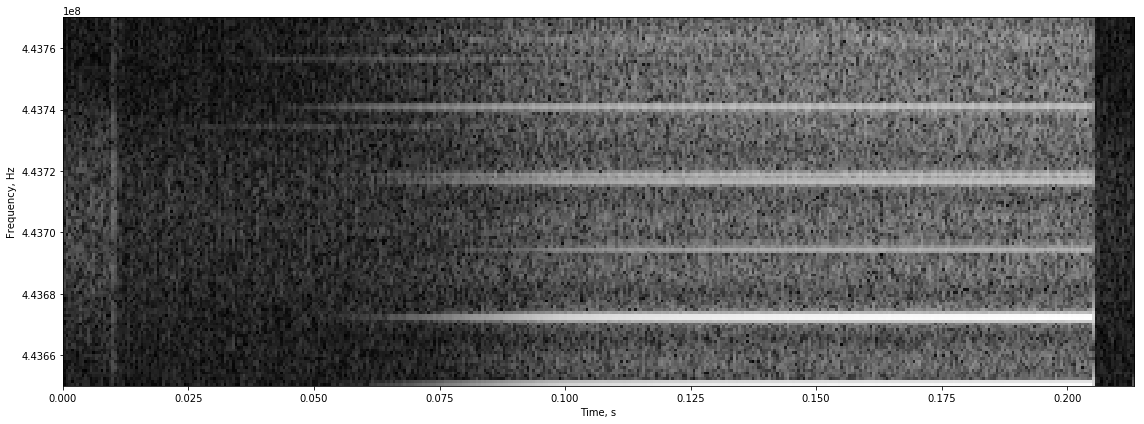

In [23]:
# Your code here
#low-pass filter
bandwidth = 15000
h = signal.firwin(128, bandwidth/2.0, nyq=fs_sdr/2, window='hanning')
y_filtered = signal.lfilter(h, 1.0, y)
#downsample
y_filtered = y_filtered[::10]
# FM demodulate
#for n in range(len(y_filtered)):
#    y_filtered = y_filtered[n]/(y_filtered[n] + 1e-6)
#y_filtered = [n / (n + 1e-6) for n in y_filtered]
h_diff = signal.remez(31,[0.0,105000.0,120000.0,120000.0],[1.05/1.2,0],Hz = 240000.0, type='differentiator')
y_fm = np.imag(signal.lfilter(h_diff, 1.0, y_filtered) * np.conj(y_filtered))
#plot spectrogram
myspectrogram_hann_ovlp(y_fm, 256, fs_sdr, fc)

#### Task
* Create narrow single side band bandpass filter by complex modulating a hanning window of length 513 to a center frequency around 2200Hz
* Filter the demodulated signal and display its magnitude (use mode='same' to compensate for the filter delay)
* You should see a linear ramp that when reaching maximum starts tapering and then becomes flat. Find the time in seconds it took from the beginning of the ramp till just before its starts to roll off. Divide that value by 2 and you've got yourself the maximum amplitude that results in a linear response!
#### Save the value of the maximum amplitude that is linear!

<IPython.core.display.Javascript object>


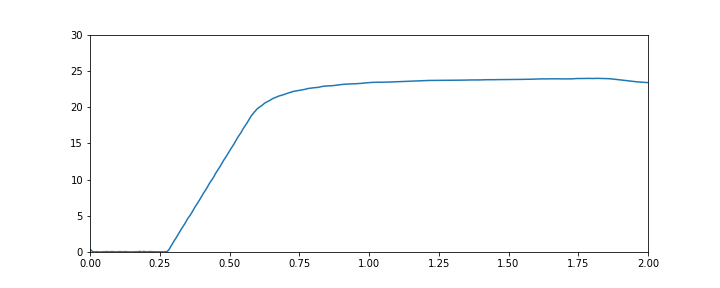

In [46]:
%matplotlib notebook
%matplotlib notebook

# Your code here








In [47]:
# return to inline plotting

%matplotlib inline

##### Measuring the Frequency Response of the Radio's Bandpass Audio Filter

As mentioned earlier, the audio input to the radio is filtered by a bandpass filter. It also emphasizes the high frequencies with a filter of approximately 6db per decade. Because later we are going to use the audio interface to transmit data, we need to know how this data is going to be affected by the filter. Much like in Lab1, we will use a chirp signal to estimate the magnitude frequency response. We will trasmit with the radio and receive using the SDR.

#### Task
* Generate a chirp from 20Hz to 5KHz over 2 seconds
* Use the amplitude you got from the previous part to scale your signal
* Transmit using the radio, and record using the SDR
* Crop based on amplidute, Filter, Decimate and FM demodulate. 
* Plot the spectrogram and the magnitude frequency response of the result


In [48]:
def genChirpPulse(Npulse, f0, f1, fs):
    #     Function generates an analytic function of a chirp pulse
    #     Inputs:
    #             Npulse - pulse length in samples
    #             f0     - starting frequency of chirp
    #             f1     - end frequency of chirp
    #             fs     - sampling frequency
    
    t1 = r_[0.0:Npulse]/fs
    Tpulse = np.float32(Npulse) / fs 
    f_of_t = f0 + (t1) / Tpulse * (f1 - f0)
    phi_of_t = 2*pi*np.cumsum(f_of_t)/fs
    pulse = np.exp(1j* phi_of_t )
    return pulse

In [49]:
# Transmit and record using the SDR

#audio apmlitude from the previous section
audio_amp = 







1


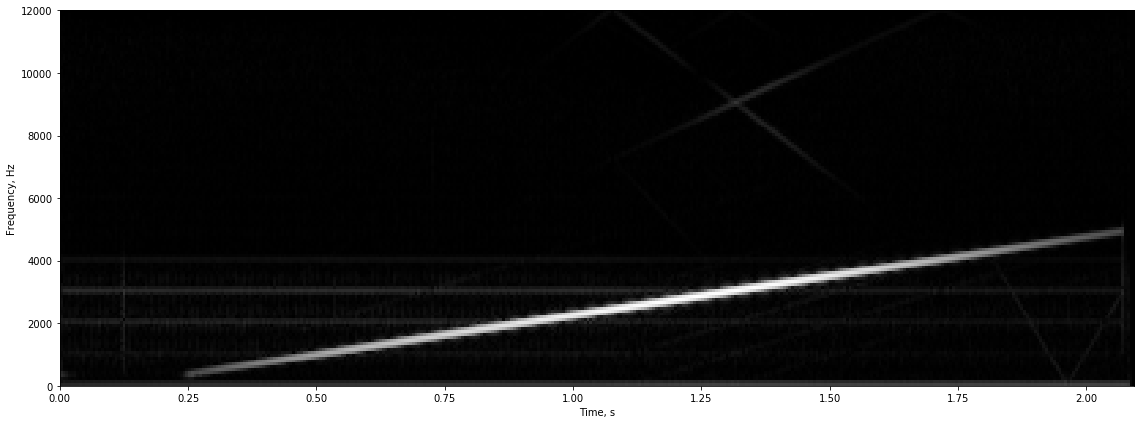

In [50]:
# Downsample and Demodulate the FM signal













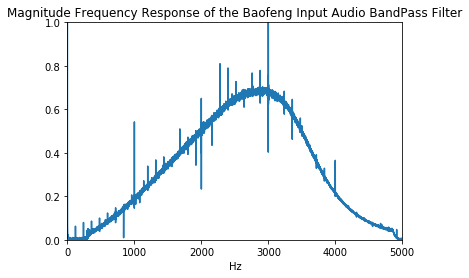

In [55]:
#Plot the spectrogram and the average power spectrum 








Another way of estimating a frequency response is to trasmit white noise. White noise, much like its name has uniform energy throughout the spectrum. 

#### Task:
* Generate 4 seconds @48.0KHz of white gaussian noise using `np.random.randn`
* Scale the maximum amplitude to the audio gain value you found previously.
* Transmit using the radio, and record using the SDR
* Crop based on amplidute, Filter, Decimate and FM demodulate.
* Plot the spectrogram 

In order to display a non-noisy spectrum, we will need to compute an average power spectrum. Use the function `avgPS` to do so.

* Use a window side of 128 and Plot the square-root of the result of the positive frequencies. 

1


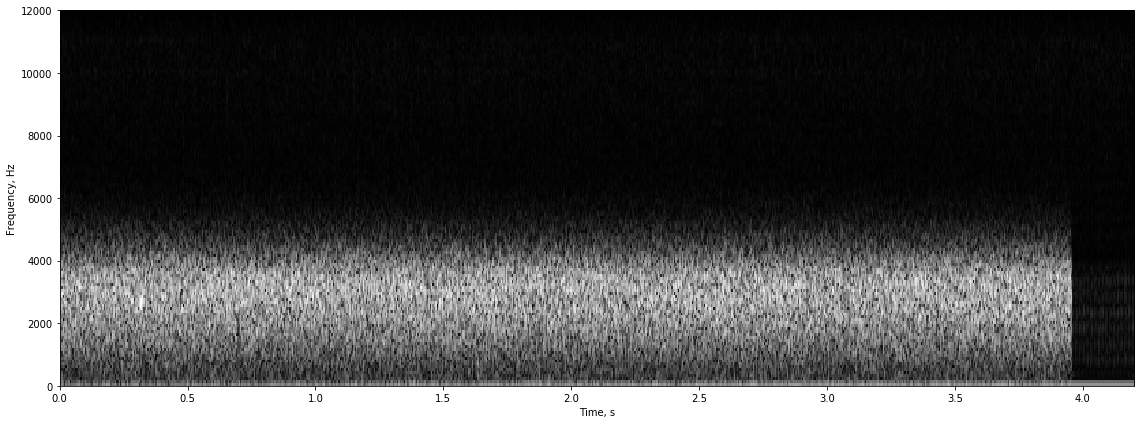

In [57]:
# generate the noise with 
# your code here:










# Your demodulation code













# display code




### Transmitting your callsign in Morse code

The next step is to see if you can transmit something more meaningful. If you are going to transmit for the first time using a computer, you might as well transmit your callsign in Morse code!

Morse code is composed of dots ( . dit) and dashes ( - dah). The timing is relative to a dot duration which is one unit long. A dah is three units long. Gap between dots and dashes within a character is one unit. A short gap between letters is three units and a gap between words is seven units.

Here's a dictionary of Morse code:



* Implement a function `sig = text2Morse(text, fc, fs,dt)`. The function will take a string and convert it to a tone signal that plays the morse code of the text. The function will also take 'fc' the frequency of the tones (800-900Hz sounds nice), 'fs' the sampling frequency and 'dt' the morse unit time (hence the speed, 50-75ms recommended).
* Transmit your call sign! You can use this function to identify yourself before, during and after a transmission from now on.
* Validate the code by capturing a spectrogram using the SDR



In [24]:
def text2Morse(text,fc,fs,dt):
    CODE = {'A': '.-',     'B': '-...',   'C': '-.-.', 
        'D': '-..',    'E': '.',      'F': '..-.',
        'G': '--.',    'H': '....',   'I': '..',
        'J': '.---',   'K': '-.-',    'L': '.-..',
        'M': '--',     'N': '-.',     'O': '---',
        'P': '.--.',   'Q': '--.-',   'R': '.-.',
     	'S': '...',    'T': '-',      'U': '..-',
        'V': '...-',   'W': '.--',    'X': '-..-',
        'Y': '-.--',   'Z': '--..',
        
        '0': '-----',  '1': '.----',  '2': '..---',
        '3': '...--',  '4': '....-',  '5': '.....',
        '6': '-....',  '7': '--...',  '8': '---..',
        '9': '----.',

        ' ': ' ', "'": '.----.', '(': '-.--.-',  ')': '-.--.-',
        ',': '--..--', '-': '-....-', '.': '.-.-.-',
        '/': '-..-.',   ':': '---...', ';': '-.-.-.',
        '?': '..--..', '_': '..--.-'
        }
    
    Ndot= np.int32(1.0*fs*dt)
    Ndah = 3*Ndot
    
    sdot = np.sin(2*pi*fc*r_[0.0:Ndot]/fs)
    sdah = np.sin(2*pi*fc*r_[0.0:Ndah]/fs)
    
    # convert to dit dah
    mrs = ""
    for char in text:
        mrs = mrs + CODE[char.upper()] + "*"
    
    sig = zeros(1)
    for char in mrs:
        if char == " ":
            sig = np.concatenate((sig,zeros(Ndot*7)))
        if char == "*":
            sig = np.concatenate((sig,zeros(Ndot*3)))
        if char == ".":
            sig = np.concatenate((sig,sdot,zeros(Ndot)))
        if char == "-":
            sig = np.concatenate((sig,sdah,zeros(Ndot)))
    return sig
            
    

In [27]:

fs = 240000
fc = 443650000 
sdr = RtlSdr()
sdr.sample_rate = fs    # sampling rate
sdr.gain = gaincalib
sdr.center_freq = fc
sdr.set_freq_correction(int(ppmcalib))


YOURCALLSIGN="KM6BKP"
audio_gain = 1.2


callsign = text2Morse(YOURCALLSIGN,850,48000,75e-3)*audio_gain
callsign = np.concatenate((np.zeros(4800),callsign))                      



GPIO.output(PTT, GPIO.HIGH)
sd.play(callsign,samplerate=48000,device=5,  blocking=False)
y = sdr.read_samples(256000*5)
sdr.close()
GPIO.output(PTT, GPIO.LOW)


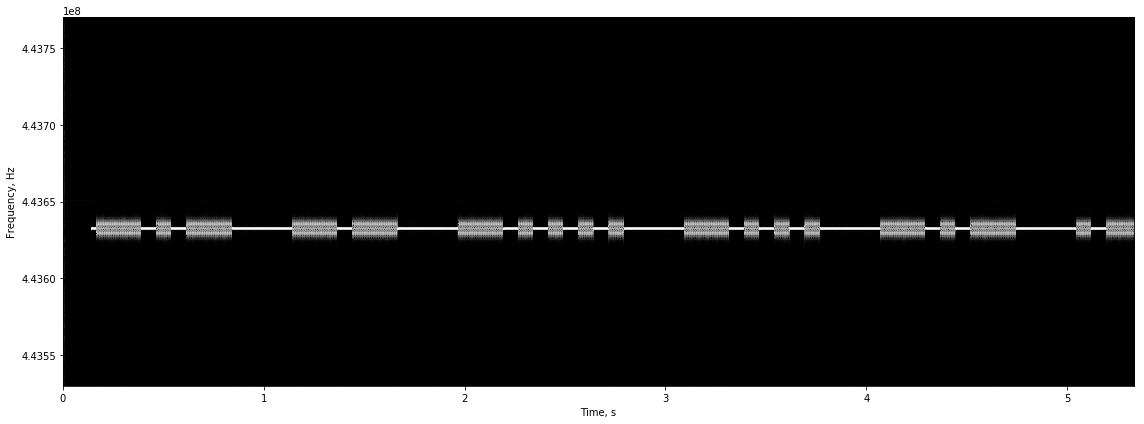

In [28]:
tt,ff,xmf = myspectrogram_hann_ovlp(y, 512, fs, fc,dbf = 30)

